In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchinfo pandas pillow scikit-learn albumentations

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

SEED = 100604
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {DEVICE}")

Menggunakan device: cuda


In [ ]:
DRIVE_ROOT = "/content/drive/MyDrive/3r-iteradl/"
DATASET_PATH = os.path.join(DRIVE_ROOT, "dataset/")
MODEL_SAVE_PATH = os.path.join(DRIVE_ROOT, "models/")
TRAIN_CSV_PATH = os.path.join(DATASET_PATH, "train.csv")

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"Path dataset: {DATASET_PATH}")
print(f"Path file train.csv: {TRAIN_CSV_PATH}")
print(f"Path untuk menyimpan model: {MODEL_SAVE_PATH}")

Path dataset: /content/drive/MyDrive/3r-iteradl/dataset/
Path file train.csv: /content/drive/MyDrive/3r-iteradl/dataset/train.csv
Path untuk menyimpan model: /content/drive/MyDrive/3r-iteradl/models/


In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH)

print("Lima baris pertama dari data:")
display(df.head())

print("\nInfo DataFrame:")
df.info()

Lima baris pertama dari data:


,filename,label
0,0001.jpg,gado_gado
1,0002.jpg,gado_gado
2,0003.jpg,rendang
3,0004.jpg,bakso
4,0005.jpg,bakso



Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1108 non-null   object
 1   label     1108 non-null   object
dtypes: object(2)
memory usage: 17.4+ KB


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class_names = sorted(df['label'].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for i, name in enumerate(class_names)}

print(f"Peta kelas yang akan digunakan: {class_to_idx}")

class IndonesianFoodDataset(Dataset):
    def __init__(self, df, img_dir, class_map, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, "train", img_name)
        image = Image.open(img_path).convert("RGB")

        label_str = self.df.iloc[idx, 1]
        label = self.class_to_idx[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

Peta kelas yang akan digunakan: {'bakso': 0, 'gado_gado': 1, 'nasi_goreng': 2, 'rendang': 3, 'soto_ayam': 4}


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label']
)

train_dataset = IndonesianFoodDataset(df=train_df, img_dir=DATASET_PATH, class_map=class_to_idx, transform=train_transform)
val_dataset = IndonesianFoodDataset(df=val_df, img_dir=DATASET_PATH, class_map=class_to_idx, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Jumlah data latih: {len(train_dataset)}")
print(f"Jumlah data validasi: {len(val_dataset)}")
print(f"Jumlah batch di train_loader: {len(train_loader)}")
print(f"Jumlah batch di val_loader: {len(val_loader)}")

Jumlah data latih: 886
Jumlah data validasi: 222
Jumlah batch di train_loader: 28
Jumlah batch di val_loader: 7


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class PlainBlock(nn.Module):
    """
    Plain Block without residual connection.
    This is equivalent to a ResNet BasicBlock but without the skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PlainBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample

    def forward(self, x):
        # Store input for potential downsampling
        identity = x

        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsample to identity if needed (for dimension matching)
        if self.downsample is not None:
            identity = self.downsample(identity)

        # NO RESIDUAL CONNECTION HERE (this is the key difference from ResNet)
        # In ResNet, we would do: out += identity
        # But in Plain network, we just apply ReLU directly

        out = F.relu(out)

        return out

In [ ]:
class Plain34(nn.Module):
    """
    Plain-34 Network: ResNet-34 architecture without residual connections.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Plain blocks:
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Fully Connected layer
    """

    def __init__(self, num_classes=5):
        super(Plain34, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Plain block stages
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple PlainBlocks.

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(PlainBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(PlainBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv + bn + relu + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # Plain block stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final classification layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
def create_plain34(num_classes=5):
    """
    Factory function to create Plain-34 model.

    Args:
        num_classes: Number of output classes (default: 5 for Indonesian food dataset)

    Returns:
        Plain34 model instance
    """
    return Plain34(num_classes=num_classes)

def test_model():
    """
    Test function to verify the model works correctly.
    This function creates a model and prints its architecture summary.
    """
    print("Creating Plain-34 model...")
    model = create_plain34(num_classes=5)

    # Print model summary
    print("\n" + "="*50)
    print("PLAIN-34 MODEL ARCHITECTURE SUMMARY")
    print("="*50)

    # Test with typical input size for image classification (224x224)
    try:
        summary(model, input_size=(1, 3, 224, 224), verbose=1)
    except Exception as e:
        print(f"Error in torchinfo summary: {e}")
        print("Trying manual forward pass...")

        # Manual test
        model.eval()
        with torch.no_grad():
            test_input = torch.randn(1, 3, 224, 224)
            output = model(test_input)
            print(f"Input shape: {test_input.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Expected output shape: (1, 5)")
            print(f"Model works correctly: {output.shape == (1, 5)}")

    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

if __name__ == "__main__":
    # Test the model when running this file directly
    model = test_model()

    print("\n" + "="*50)
    print("MODEL READY FOR TRAINING!")
    print("="*50)
    print("Next steps:")
    print("1. Load your Indonesian food dataset")
    print("2. Set up data loaders")
    print("3. Define loss function and optimizer")
    print("4. Train the model")
    print("5. Compare with ResNet-34 (with residual connections)")

Creating Plain-34 model...

PLAIN-34 MODEL ARCHITECTURE SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
Plain34                                  [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─PlainBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─PlainBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│  

In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    start_time = time.time()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Setiap epoch memiliki fase training dan validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model ke training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model ke evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterasi melewati data.
            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Nol-kan gradien parameter
                optimizer.zero_grad()

                # Hanya hitung gradien di fase training
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimasi hanya di fase training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Kumpulkan statistik
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Simpan history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Simpan model jika mendapatkan akurasi validasi terbaik
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Simpan model terbaik ke file
                torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model.pth'))
                print("Model terbaik berhasil disimpan!")


    time_elapsed = time.time() - start_time
    print(f'\nTraining selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Akurasi validasi terbaik: {best_acc:4f}')

    # Muat bobot model terbaik
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.show()

Memulai pelatihan untuk model Plain-34 (Baseline)...
Epoch 1/15
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.6343 Acc: 0.2133
val Loss: 5.2944 Acc: 0.1712
Model terbaik berhasil disimpan!
Epoch 2/15
----------
train Loss: 1.6196 Acc: 0.2144
val Loss: 3.0537 Acc: 0.3333
Model terbaik berhasil disimpan!
Epoch 3/15
----------
train Loss: 1.5715 Acc: 0.2822
val Loss: 1.5898 Acc: 0.2432
Epoch 4/15
----------
train Loss: 1.5927 Acc: 0.2438
val Loss: 1.7835 Acc: 0.1937
Epoch 5/15
----------
train Loss: 1.5907 Acc: 0.2381
val Loss: 1.6135 Acc: 0.2793
Epoch 6/15
----------
train Loss: 1.5262 Acc: 0.3115
val Loss: 2.4919 Acc: 0.2072
Epoch 7/15
----------
train Loss: 1.4913 Acc: 0.3126
val Loss: 3.8745 Acc: 0.2477
Epoch 8/15
----------
train Loss: 1.4160 Acc: 0.3442
val Loss: 1.5593 Acc: 0.3468
Model terbaik berhasil disimpan!
Epoch 9/15
----------
train Loss: 1.3806 Acc: 0.3826
val Loss: 1.6167 Acc: 0.3288
Epoch 10/15
----------
train Loss: 1.3127 Acc: 0.4165
val Loss: 1.2213 Acc: 0.4955
Model terbaik berhasil disimpan!
Epoch 11/15
----------
train Loss: 1.2944 Acc: 0.4345
val Loss: 1.295

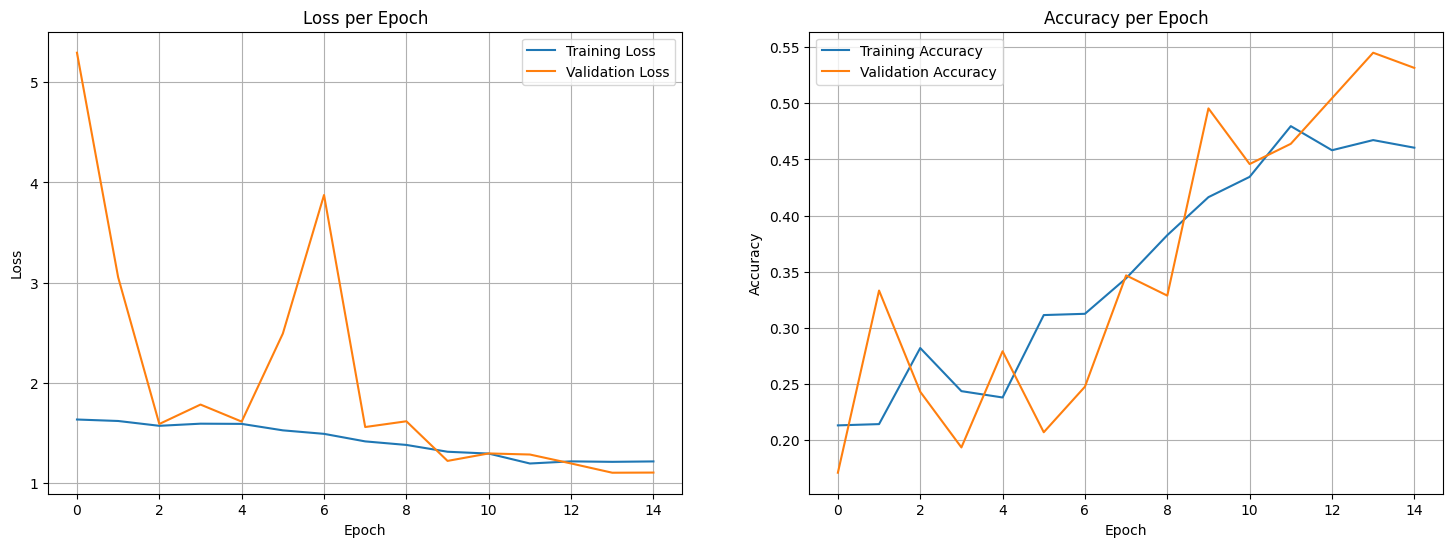

In [ ]:
# --- TAHAP 1: TRAINING PLAIN-34 ---

print("Memulai pelatihan untuk model Plain-34 (Baseline)...")

# Buat model Plain-34
plain_model = Plain34(num_classes=5).to(DEVICE)

# Cek arsitektur dan jumlah parameter
summary(plain_model, input_size=(32, 3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer_plain = torch.optim.Adam(plain_model.parameters(), lr=0.001)

NUM_EPOCHS = 15
plain_model, plain_history = train_model(
    model=plain_model,
    criterion=criterion,
    optimizer=optimizer_plain,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS
)

print("\nGrafik Hasil Pelatihan Plain-34:")
plot_history(plain_history)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = F.relu(out)

        return out

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self._make_stage(64, 64, 3, stride=1)
        self.stage2 = self._make_stage(64, 128, 4, stride=2)
        self.stage3 = self._make_stage(128, 256, 6, stride=2)
        self.stage4 = self._make_stage(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Memulai pelatihan untuk model ResNet-34 (Dengan Residual Connection)...
Epoch 1/15
----------
train Loss: 1.7128 Acc: 0.3273
val Loss: 1.6770 Acc: 0.3288
Model terbaik berhasil disimpan!
Epoch 2/15
----------
train Loss: 1.3540 Acc: 0.4165
val Loss: 1.4134 Acc: 0.3919
Model terbaik berhasil disimpan!
Epoch 3/15
----------
train Loss: 1.3052 Acc: 0.4481
val Loss: 1.1915 Acc: 0.5405
Model terbaik berhasil disimpan!
Epoch 4/15
----------
train Loss: 1.1616 Acc: 0.5406
val Loss: 1.1066 Acc: 0.5811
Model terbaik berhasil disimpan!
Epoch 5/15
----------
train Loss: 1.1461 Acc: 0.5497
val Loss: 0.9689 Acc: 0.6396
Model terbaik berhasil disimpan!
Epoch 6/15
----------
train Loss: 1.0678 Acc: 0.5880
val Loss: 2.4241 Acc: 0.3919
Epoch 7/15
----------
train Loss: 1.0966 Acc: 0.5779
val Loss: 2.0615 Acc: 0.5270
Epoch 8/15
----------
train Loss: 0.9633 Acc: 0.6512
val Loss: 1.7618 Acc: 0.3559
Epoch 9/15
----------
train Loss: 0.9722 Acc: 0.6524
val Loss: 1.2202 Acc: 0.5586
Epoch 10/15
----------
tr

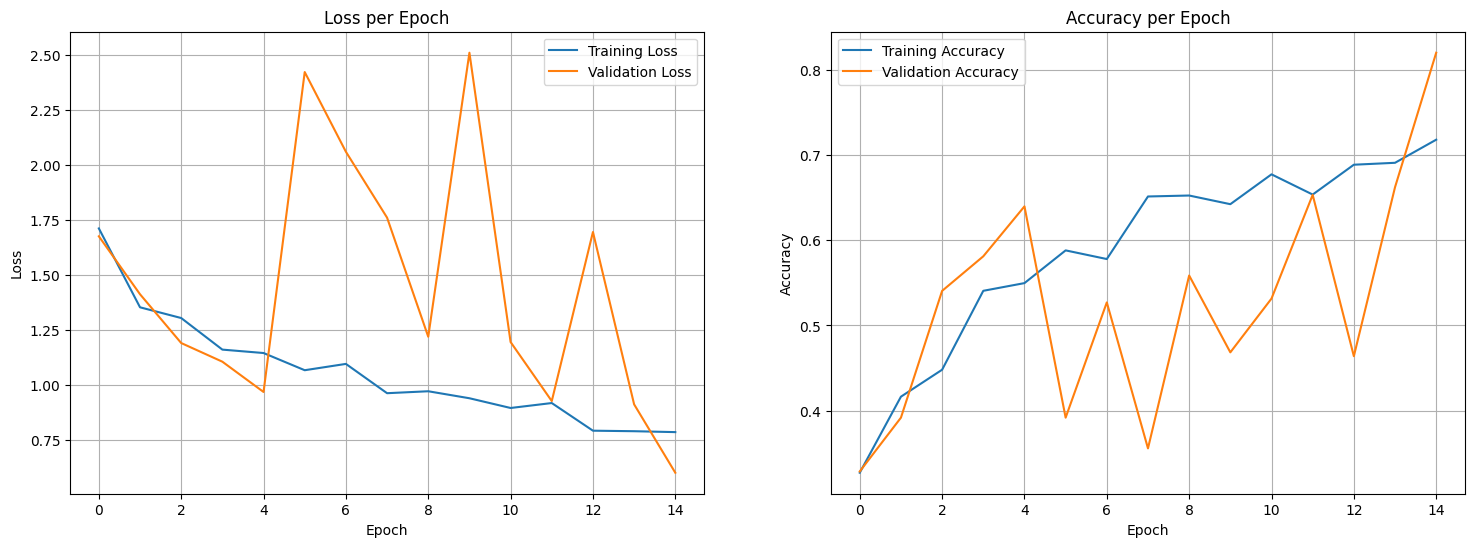

In [ ]:
# --- TAHAP 2: TRAINING RESNET-34 ---

print("Memulai pelatihan untuk model ResNet-34 (Dengan Residual Connection)...")

# Buat model ResNet-34
resnet_model = ResNet34(num_classes=5).to(DEVICE)

# Cek arsitektur
summary(resnet_model, input_size=(32, 3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

resnet_model, resnet_history = train_model(
    model=resnet_model,
    criterion=criterion,
    optimizer=optimizer_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS
)

print("\nGrafik Hasil Pelatihan ResNet-34:")
plot_history(resnet_history)

In [ ]:
import pandas as pd

plain_best_acc = max(plain_history['val_acc'])
resnet_best_acc = max(resnet_history['val_acc'])

print(f"Akurasi Validasi Terbaik Plain-34: {plain_best_acc:.2%}")
print(f"Akurasi Validasi Terbaik ResNet-34: {resnet_best_acc:.2%}")

comparison_df = pd.DataFrame({
    'Model': ['Plain-34 (Baseline)', 'ResNet-34'],
    'Best Validation Accuracy': [plain_best_acc, resnet_best_acc]
})

display(comparison_df)

Akurasi Validasi Terbaik Plain-34: 54.50%
Akurasi Validasi Terbaik ResNet-34: 81.98%


,Model,Best Validation Accuracy
0,Plain-34 (Baseline),0.545045
1,ResNet-34,0.819820


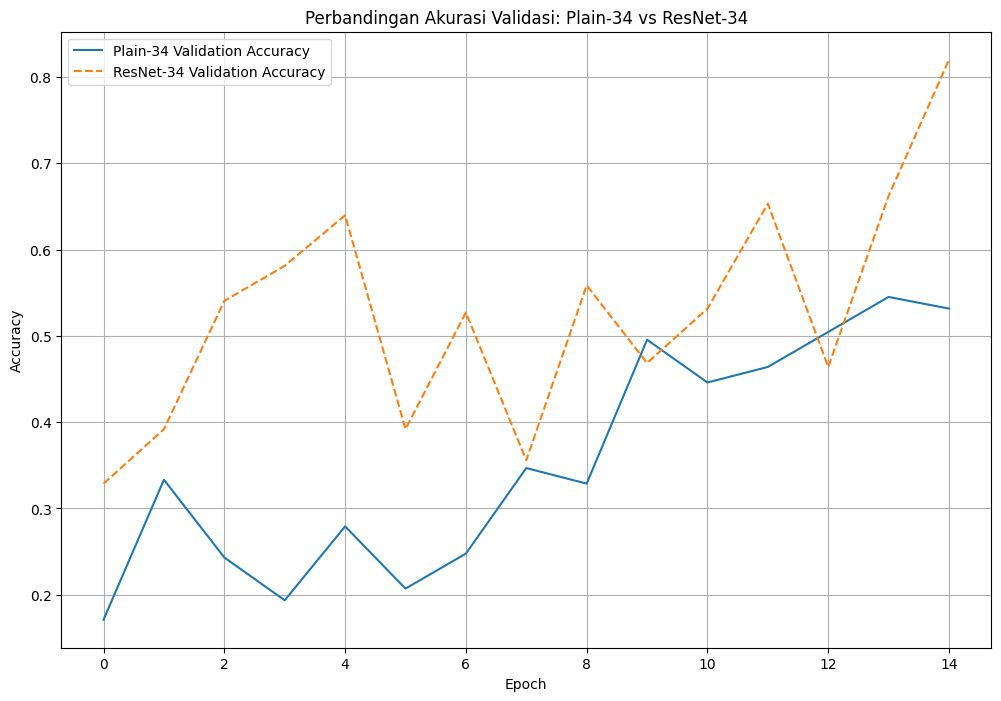

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(plain_history['val_acc'], label='Plain-34 Validation Accuracy')
plt.plot(resnet_history['val_acc'], label='ResNet-34 Validation Accuracy', linestyle='--')
plt.title('Perbandingan Akurasi Validasi: Plain-34 vs ResNet-34')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()